## Instala paquetes importa librerías

In [ ]:
!pip install yfinance
!pip install matplotlib

     |████████████████████████████████| 5.5MB 6.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=dbdd29da17253bf0658f8eadaf66d080410389105aa2d122cc37a53ec18e7c79
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from datetime import timedelta
pd.set_option('mode.chained_assignment', None)

## Define función para calcular el histograma y guardarse únicamente lo que sirve

In [ ]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.width', 1000)

def MACD(ticker):
  global df_candidatas
  global df_confirmadas
  global df_reversiones_candidatas
  global actualDate
  global df
  today = date.today()
  today = today + timedelta(days=1)
  start_date = today + timedelta(days=-500)
  df = yf.download(ticker, start=start_date, end=today)
  df = df[['Close', 'Volume']]
  mean = df['Volume'].mean()
  std = df['Volume'].std()
  df['Volume'] = (df['Volume'] - mean)/std * 100
  df.reset_index(level=0, inplace=True)
  df.columns=['ds','y', 'vol']
  actualDate = df['ds'].max()
  period = 12
  sma = df['y'].rolling(period, min_periods=period).mean()
  idx_start = sma.isna().sum() + 1 - period
  idx_end = idx_start + period
  sma = sma[idx_start: idx_end]
  rest = df['y'][idx_end:]
  ema = pd.concat([sma, rest]).ewm(span=period, adjust=False).mean()
  df['exp1'] = ema
  period = 26
  sma = df['y'].rolling(period, min_periods=period).mean()
  idx_start = sma.isna().sum() + 1 - period
  idx_end = idx_start + period
  sma = sma[idx_start: idx_end]
  rest = df['y'][idx_end:]
  ema = pd.concat([sma, rest]).ewm(span=period, adjust=False).mean()
  df['exp2'] = ema
  macd = df['exp1']-df['exp2']
  df['macd'] = macd
  df['exp3'] = macd.ewm(span=9, adjust=False).mean()
  df['histog'] = df['macd'] - df['exp3'] 
  df['histog_1b'] = df.histog.shift(1) 
  df['histog_2b'] = df.histog.shift(2) 
  df['histog_3b'] = df.histog.shift(3) 
  df['histog_4b'] = df.histog.shift(4)

  df_candidatas = df[((df.histog > 0) & (df.histog_1b < 0))|((df.histog < 0) & (df.histog_1b > 0))]
  df_candidatas['anterior_day'] = df_candidatas.ds.shift(1) 
  df_candidatas['anterior_price'] = df_candidatas.y.shift(1) 
  df_candidatas = df_candidatas[df_candidatas.ds == actualDate]
  if len(df_candidatas) !=  0:
    df_candidatas.loc[(df['histog'] > 0), 'tipo'] = 'Alcista'
    df_candidatas.loc[(df['histog'] < 0), 'tipo'] = 'Bajista'
    df_candidatas['Activo'] = ticker

  df_reversiones_candidatas = df[((df.histog < 0) & (df.histog > df.histog_1b) & (df.histog_1b > df.histog_2b))|
                                 ((df.histog > 0) & (df.histog < df.histog_1b) & (df.histog_1b < df.histog_2b) & (df.histog_2b < df.histog_3b))]  
  df_reversiones_candidatas.loc[(df['histog'] < 0), 'tipo'] = 'Reversión alcista'
  df_reversiones_candidatas.loc[(df['histog'] > 0), 'tipo'] = 'Reversión bajista'
  df_reversiones_candidatas['Activo'] = ticker
  df_reversiones_candidatas['anterior_reversion'] = df_reversiones_candidatas.tipo.shift(1)
  if len(df_reversiones_candidatas) !=  0:
    df_reversiones_candidatas = df_reversiones_candidatas[((df_reversiones_candidatas.tipo == 'Reversión alcista') & (df_reversiones_candidatas.anterior_reversion == 'Reversión bajista'))
    |((df_reversiones_candidatas.tipo == 'Reversión bajista') & (df_reversiones_candidatas.anterior_reversion == 'Reversión alcista'))]   
    df_reversiones_candidatas['anterior_day'] = df_reversiones_candidatas.ds.shift(1)
    df_reversiones_candidatas['anterior_price'] = df_reversiones_candidatas.y.shift(1)
    if len(df_reversiones_candidatas) !=  0:
      df_reversiones_candidatas = df_reversiones_candidatas[df_reversiones_candidatas.ds == actualDate]
  
  '''
  df_confirmadas = df[(((df.histog > 0) & (df.histog_1b > 0) & (df.histog > df.histog_1b) & (df.histog_2b < 0)) |
                      ((df.histog < 0) & (df.histog_1b < 0) & (df.histog < df.histog_1b) & (df.histog_2b > 0)))]
  df_confirmadas['anterior_day'] = df_confirmadas.ds.shift(1) 
  df_confirmadas['anterior_price'] = df_confirmadas.y.shift(1) 
  df_confirmadas = df_confirmadas[df_confirmadas.ds == actualDate]
  if len(df_confirmadas) !=  0:
    df_confirmadas.loc[(df['histog'] > 0), 'tipo'] = 'Alcista'
    df_confirmadas.loc[(df['histog'] < 0), 'tipo'] = 'Bajista'
    df_confirmadas['Activo'] = ticker
  '''

## Define función para graficar

In [ ]:
def plot(ticker, desde, hasta):
  global df
  today = date.today()
  hasta = hasta * -1 + 1
  termina = today + timedelta(days=hasta)
  desde = desde * -1
  empieza = today + timedelta(days=desde)
  df = yf.download(ticker, start=empieza, end=termina)
  df = df[['Close', 'Volume']]
  mean = df['Volume'].mean()
  std = df['Volume'].std()
  df['Volume'] = (df['Volume'] - mean)/std * 100
  df.reset_index(level=0, inplace=True)
  df.columns=['ds','y', 'vol']
  actualDate = df['ds'].max()
  period = 12
  sma = df['y'].rolling(period, min_periods=period).mean()
  idx_start = sma.isna().sum() + 1 - period
  idx_end = idx_start + period
  sma = sma[idx_start: idx_end]
  rest = df['y'][idx_end:]
  ema = pd.concat([sma, rest]).ewm(span=period, adjust=False).mean()
  df['exp1'] = ema
  period = 26
  sma = df['y'].rolling(period, min_periods=period).mean()
  idx_start = sma.isna().sum() + 1 - period
  idx_end = idx_start + period
  sma = sma[idx_start: idx_end]
  rest = df['y'][idx_end:]
  ema = pd.concat([sma, rest]).ewm(span=period, adjust=False).mean()
  df['exp2'] = ema
  macd = df['exp1']-df['exp2']
  df['macd'] = macd
  df['exp3'] = macd.ewm(span=9, adjust=False).mean()
  df['histog'] = df['macd'] - df['exp3'] 
  df = df[['ds', 'y', 'vol', 'histog']].dropna()

  ds = df[['ds']].to_numpy()
  y = df[['y']].to_numpy()

  ds_list = tuple(ds.reshape(1, -1)[0])
  histog_list = df['histog'].tolist()
  col = []
  for val in histog_list:
      if val < 0:
          col.append('red')
      elif val >= 0:
          col.append('green')

  y_pos = np.arange(len(ds_list))

  plt.figure(figsize=(12,8))

  plt.subplot(211)
  plt.plot(ds, y)
  plt.subplot(212)
  plt.bar(y_pos, histog_list, color=col)
  plt.show()

## Junta todo a la fecha y devuelve análisis al presente:


1.   **Cambios de signo**: En el último ejercicio disponible el histograma cruzó (o está cruzando) el 0 en sentido positivo o negativo.
2.   **Cambios de tendencia**: En el último ejercicio disponible completó (o está completando) dos ascensos en el histograma con signo negativo (señal alcista) o tres descensos en el histograma con signo positivo (señal bajista). Solo se muestra la primera vez, por lo que si la tendencia sigue al día siguiente no se mostrará. [Parámetros](https://colab.research.google.com/drive/1uyyI_iB-DcfXInSVlbcdnwX6Nfxn-UPw).

*   No se muestran confirmaciones: quedó [mostrado](https://colab.research.google.com/drive/1xyf5p8aGisevRqmrV6NkQtHxsqF5KYbA) que el cruce de signos está más cerca del final que del principio del reflejo en los precios, por lo que no se espera todavía más.

In [ ]:
candidatas = pd.DataFrame()
confirmadas = pd.DataFrame()
reversiones = pd.DataFrame()

for ticker in (
"ALUA.BA",
"CRES.BA",
"EDN.BA",
"GGAL.BA",
"MIRG.BA",
"PAMP.BA",
"SUPV.BA",
"TECO2.BA",
"TGSU2.BA",
"YPFD.BA",

"MSFT.ba",
"AAPL.ba",
"MELI.ba",
"GOOGL.ba"
):
  MACD(ticker)
  if len(df_candidatas) !=  0:
    candidatas = candidatas.append(df_candidatas, ignore_index=True)
  '''
  if len(df_confirmadas) !=  0:
    confirmadas = confirmadas.append(df_confirmadas, ignore_index=True)
  '''
  if len(df_reversiones_candidatas) !=  0:
    reversiones = reversiones.append(df_reversiones_candidatas, ignore_index=True)

'''
print("confirmadas:")
if len(confirmadas) !=  0:
  confirmadas = confirmadas[['ds', 'Activo', 'tipo', 'y', 'vol', 'histog', 'histog_1b', 'histog_2b', 'anterior_day', 'anterior_price']].sort_values(by=['ds'])
  print(confirmadas)
'''
print("\n")

print("CAMBIOS DE SIGNO:")
if len(candidatas) !=  0:
  candidatas = candidatas[['ds', 'Activo', 'tipo', 'y', 'vol', 'histog', 'histog_1b', 'histog_2b', 'anterior_day', 'anterior_price']].sort_values(by=['ds'])
  print(candidatas)

print("\n")

print("CAMBIOS DE TENDENCIA:")
if len(reversiones) !=  0:
  reversiones = reversiones[['ds', 'Activo', 'tipo', 'y', 'vol', 'histog', 'histog_1b', 'histog_2b', 'anterior_day', 'anterior_price']].sort_values(by=['ds'])
  print(reversiones)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


CAMBIOS DE SIGNO:


CAMBIOS DE T

## Explorar una serie completa

[*********************100%***********************]  1 of 1 completed


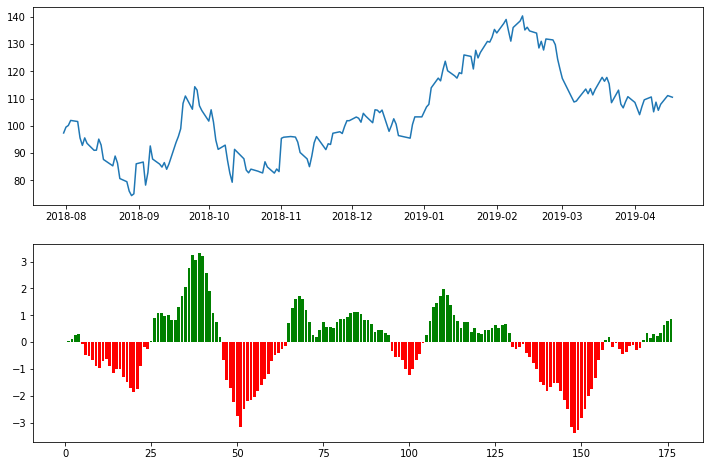

In [ ]:
plot("GGAL.BA", 900, 600)